## Compare TMRCAs of sample pairs across nextstrain builds




In [9]:
## Imports & common functions

import requests
import os
import json
import augur.utils
import treetime.utils
from collections import defaultdict

datetime_from_numeric = treetime.utils.datetime_from_numeric

def get_and_cache_json(name):
  fn = os.path.join(output_dir, name)
  if os.path.isfile(fn):
    print("cache hit", name)
    with open(fn) as fh:
      return json.load(fh)
  data = requests.get(f"https://data.nextstrain.org/{name}").json()
  print("downloading and caching", name)
  with open(fn, 'w') as fh:
    json.dump(data, fh)
  return data

def mkdir(p):
  if not os.path.isdir(p):
    os.makedirs(p)

## Get the database

Database is behind https://nextstrain.org/search/sars-cov-2 and links strains to the (datestamped) datasets where they appear

In [10]:
output_dir = "./cache"
mkdir(output_dir)
db = get_and_cache_json("search_sars-cov-2.json")

cache hit search_sars-cov-2.json


# Define what pairs you want to scan (can be multiple pairs)

In [11]:
queries = [
    ("Algeria/G0860_2262/2020", "Germany/NRW-MPP-30/2020"), # 20C
    ("HongKong/HKU-200723-008/2020", "Russia/Buryatia-87104/2020"), #20A
    ("Norway/2799/2020", "Norway/2851/2020"),
    ("NewZealand/20VR0994/2020", "Iceland/13/2020")
]

## Loop through user-defined strain pairs and record datasets where they appear together

In [13]:
def get_pairs(db):
    data = []
    strains = [*db["strainMap"].keys()]
    for query in queries:
        datasets_in_common = set(db["strainMap"][query[0]]) & set(db["strainMap"][query[1]])
        if len(datasets_in_common):
            data.append({
                "strains": query,
                "datasets": [db["datasets"][idx] for idx in datasets_in_common]
            })
    return data


pairs = get_pairs(db)

for p in pairs: print(f"{p['strains']} appear together in {len(p['datasets'])} datasets")


('Algeria/G0860_2262/2020', 'Germany/NRW-MPP-30/2020') appear together in 26 datasets
('HongKong/HKU-200723-008/2020', 'Russia/Buryatia-87104/2020') appear together in 5 datasets
('Norway/2799/2020', 'Norway/2851/2020') appear together in 5 datasets
('NewZealand/20VR0994/2020', 'Iceland/13/2020') appear together in 7 datasets


## For each pair {a,b} get the datasets they appear together in and parse the MRCA in each

In [21]:
from Bio import Phylo

def get_tmrca(a, b, dataset):
    t = augur.utils.json_to_tree(dataset)
    try:
        tmrca = t.common_ancestor({"name": a}, {"name": b}).node_attrs['num_date']   
    except (ValueError, TypeError) as err:
        print("\tCouldn't find MRCA of", a, b, err)
        return None
    return tmrca

for pair in pairs:
    pair["tmrcas"] = []
    print(f"Finding TMRCA of {pair['strains']}")
    for dataset in pair["datasets"]:
        data = get_and_cache_json(dataset["filename"])
        pair["tmrcas"].append(get_tmrca(*pair["strains"], data))


Finding TMRCA of ('Algeria/G0860_2262/2020', 'Germany/NRW-MPP-30/2020')
cache hit ncov_global.json
cache hit ncov_europe_2020-08-04.json
cache hit ncov_europe_2020-07-31.json
cache hit ncov_europe_2020-07-23.json
cache hit ncov_europe_2020-07-21.json
cache hit ncov_europe_2020-07-17.json
cache hit ncov_europe.json
cache hit ncov_asia_2020-07-23.json
cache hit ncov_asia_2020-07-21.json
cache hit ncov_africa_2020-07-23.json
cache hit ncov_europe_2020-08-03.json
cache hit ncov_europe_2020-07-30.json
cache hit ncov_europe_2020-07-24.json
cache hit ncov_europe_2020-07-22.json
cache hit ncov_europe_2020-07-20.json
cache hit ncov_europe_2020-07-16.json
cache hit ncov_europe_2020-07-14.json
cache hit ncov_asia_2020-07-30.json
cache hit ncov_asia_2020-07-22.json
cache hit ncov_europe_2020-07-29.json
cache hit ncov_europe_2020-07-28.json
cache hit ncov_africa_2020-07-28.json
cache hit ncov_europe_2020-07-27.json
cache hit ncov_asia_2020-07-27.json
cache hit ncov_europe_2020-07-15.json
cache hit 

## set up matplotlib & plot results on same graph

In [22]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon, PathPatch, Patch, Rectangle, Circle
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats

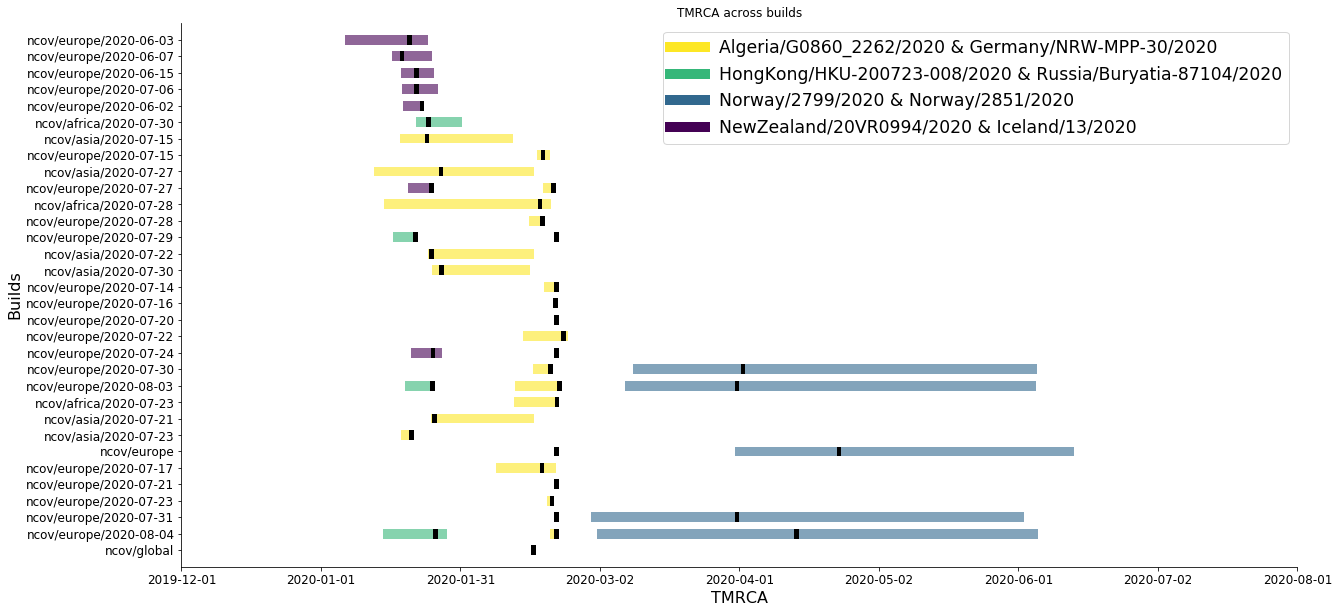

In [27]:

## MAP DATASET NAME TO Y-AXIS-VALUE
count = 1
yvalues = {}
for data in pairs:
    for idx, dataset in enumerate(data["datasets"]):
        if data["tmrcas"][idx] and dataset["filename"] not in yvalues:
            yvalues[dataset["filename"]] = count
            count += 1


fig, main_ax = plt.subplots(figsize=(20, 10))

ax = main_ax
ax.set_title("TMRCA across builds")
xrange_months = 8
xmin = 2019 + 11/12
xmax = xmin + xrange_months/12
ax.set_xlim(xmin, xmax)
ax.set_xlabel('TMRCA', size=16)
ax.set_ylim(0, count)
ax.set_ylabel('Builds', size=16)

ax.tick_params(axis='x',labelsize=12,direction='out')
ax.tick_params(axis='y',labelsize=12,direction='out')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
for pos in ["top", "right"]:
    ax.spines[pos].set_visible(False)

## COLORS
colors = [mpl.colors.rgb2hex(rgba) for rgba in mpl.cm.get_cmap('viridis_r', len(pairs)).colors]

## PLOT CONFIDENCE INTERVALS AND VALUES
bar_height = 0.6;
for pair_idx, data in enumerate(pairs):
    confidence_intervals = []
    values = []
    for idx, t in enumerate(data["tmrcas"]):
        if not t:
            continue
        yvalue = yvalues[data["datasets"][idx]["filename"]]
        confidence_intervals.append(Rectangle((t["confidence"][0], yvalue-(bar_height/2)), t["confidence"][1]-t["confidence"][0], bar_height))
        values.append(Rectangle((t["value"]-0.5/365, yvalue-(bar_height/2)), 1/365, bar_height))
    ax.add_collection(PatchCollection(confidence_intervals, facecolor=colors[pair_idx], alpha=0.6, edgecolor=None))
    ax.add_collection(PatchCollection(values, facecolor='k', alpha=1, edgecolor=None))


## X-LABELS
xticks = np.linspace(xmin, xmax, xrange_months+1)
ax.set_xticks(xticks)
ax.set_xticklabels([datetime_from_numeric(x).strftime("%Y-%m-%d") for x in xticks])


## Y-LABELS
ax.set_yticks([*yvalues.values()])
ax.set_yticklabels([d.split(".json")[0].replace("_","/") for d in [*yvalues.keys()]])


## LEGEND
ax.legend(
    [Line2D([0], [0], color=colors[idx], lw=10) for idx, _ in enumerate(pairs)],
    [f"{p['strains'][0]} & {p['strains'][1]}" for p in pairs],
    fontsize='xx-large'
)

plt.show()
